In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
resources = pd.read_csv('./outputs/eval_resources.csv')
accuracy = pd.read_csv('./outputs/eval_accuracy.csv')

Remove unnecessary/constant-valued columns from resources dataframe.

In [3]:
resources = resources.drop(columns=['PID','USER','PR','NI','S','COMMAND'])

In [4]:
def minutesToSeconds(min_sec_str):
    mins_secs = min_sec_str.split(':')
    mins = int(mins_secs[0])
    secs = float(mins_secs[1])
    return 60*mins + secs

def numCPU(cpu_use, num_cpus):
    #2.86 approximates the avg. number of threads running on each CPU
    num = 2.86 * math.ceil(float(cpu_use) / 100)
    return num

def cpuToRealTime(cpu_use, num_cpus, cpu_time):
    if (cpu_use.size != cpu_time.size):
        return
    prev_secs = minutesToSeconds(cpu_time.iloc[0])
    prev_time = prev_secs / numCPU(cpu_use.iloc[0], num_cpus)
    realtime = pd.Series([prev_time])
    for index in range(1, cpu_use.size):
        secs = minutesToSeconds(cpu_time.iloc[index])
        cpus = numCPU(cpu_use.iloc[index], num_cpus)
        if(cpus == 0):
            prev_secs = prev_secs + 2
            prev_time = prev_time + 2
        else:
            prev_time = (secs-prev_secs)/cpus + prev_time
            prev_secs = secs
        realtime = realtime.append(pd.Series([prev_time]))
    return realtime

def memoryPercentToGB(mem_use, total_mem):
    memory = pd.Series([])
    for index in range(0, mem_use.size):
        memGB = total_mem * (mem_use.iloc[index]/100)
        memory = memory.append(pd.Series([memGB]))
    return memory

In [5]:
def getModelResources(acc, res, num_models):
    acc_completion_time = acc['completionTime'].iloc[-1]
    res_completion_time = res['RUNTIME'].iloc[-1]
    
    model_resources = []
    current_model = 0;
    current_resources = pd.DataFrame([], columns = res.columns)
    model_completion_time = acc['completionTime'].iloc[current_model]
    for index, row in res.iterrows():
        if((row['RUNTIME'] > model_completion_time) & (current_model < (num_models - 1))):
            model_resources.append(current_resources)
            current_resources = pd.DataFrame([], columns = res.columns)
            current_model = current_model + 1
            model_completion_time = acc['completionTime'].iloc[current_model]
        current_resources = current_resources.append(row, ignore_index=True)
    model_resources.append(current_resources)
    return model_resources

In [6]:
def getResourceStats(models):
    maxMem = []
    meanMem = []
    minMem = []
    maxCpu = []
    meanCpu = []
    minCpu = []
    runtime = []
    for model in models:
        mem = model['MEMORY']
        cpu = model['%CPU']
        run = model['RUNTIME']
        time = run.iloc[-1] - run.iloc[0]
        runtime.append(time)
        maxMem.append(mem.max())
        minMem.append(mem.min())
        meanMem.append(mem.mean())
        maxCpu.append(cpu.max())
        minCpu.append(cpu.min())
        meanCpu.append(cpu.mean())
    stats = {}
    stats['maxMem'] = maxMem
    stats['minMem'] = minMem
    stats['meanMem'] = meanMem
    stats['maxCpu'] = maxCpu
    stats['minCpu'] = minCpu
    stats['meanCpu'] = meanCpu
    stats['runtime'] = runtime
    return stats      

Add column to resources in order to have a meaningful 'time' value. TIME+ represents CPU time, not real time.

In [7]:
cpu_time = resources['TIME+']
cpu_use = resources['%CPU']
runtime = cpuToRealTime(cpu_use, 64, cpu_time)

mem_use = resources['%MEM']
memory = memoryPercentToGB(mem_use, 240)

resources['RUNTIME'] = runtime.values
resources['MEMORY'] = memory.values

Split the resource use data into chunks corresponding to each (model, dataset) combination.

In [8]:
model_resources = getModelResources(accuracy, resources, 28)

Add meaningful statistics to the dataframe summarizing each (model, dataset) combination & accuracy.

In [9]:
model_stats = getResourceStats(model_resources)

accuracy['minCpu'] = np.array(model_stats['minCpu'])
accuracy['meanCpu'] = np.array(model_stats['meanCpu'])
accuracy['maxCpu'] = np.array(model_stats['maxCpu'])
accuracy['minMem'] = np.array(model_stats['minMem'])
accuracy['meanMem'] = np.array(model_stats['meanMem'])
accuracy['maxMem'] = np.array(model_stats['maxMem'])
accuracy['runtime'] = np.array(model_stats['runtime'])

In [10]:
def plotCpuUse(model, dataset, num_models):
    plt.figure()
    plot = model.plot.line(y='%CPU', legend=False)
    plot.set_ylabel('% of CPU Used (64 Cores)')
    plot.set_title('CPU Use of {} Model(s) on {} Dataset'.format(str(num_models), dataset))
    plt.savefig('plots/{}_{}_CPU.png'.format(str(num_models), dataset))

In [11]:
def plotMemoryUse(model, dataset, num_models):
    plt.figure()
    plot = model.plot.line(y='MEMORY', legend=False)
    plot.set_ylabel('Gigabyes of Memory Used')
    plot.set_title('Memory Use of {} Model(s) on {} Dataset'.format(str(num_models), dataset))
    plt.savefig('plots/{}_{}_Mem.png'.format(str(num_models), dataset))  

In [12]:
def plotRuntime(acc, dataset):
    target = acc['dataset'] == dataset
    values = acc[target]
    plt.figure()
    plot = values.plot.bar(x='numModels', y='runtime', legend=False)
    plot.set_xlabel('# Models in Ensemble')
    plot.set_ylabel('Evalutation Time (seconds)')
    plot.set_title('Runtime of Language Models on {} Dataset'.format(dataset))
    plt.savefig('plots/{}Runtime.png'.format(dataset))

In [13]:
def plotAccuracies(acc, dataset):
    target = acc['dataset'] == dataset
    values = acc[target]
    plt.figure()
    plot = values.plot.bar(x='numModels', y='accuracy', legend=False)
    plot.set_xlabel('# Models in Ensemble')
    plot.set_ylabel('Accuracy')
    plot.set_title('Accuracy of Language Models on {} Dataset'.format(dataset))
    plt.savefig('plots/{}Acc'.format(dataset))

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

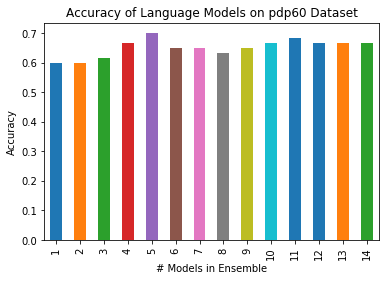

<Figure size 432x288 with 0 Axes>

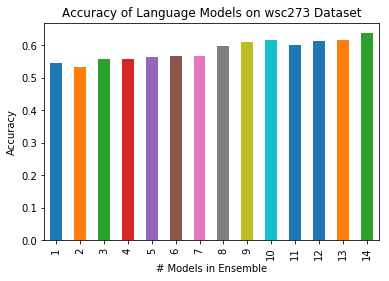

<Figure size 432x288 with 0 Axes>

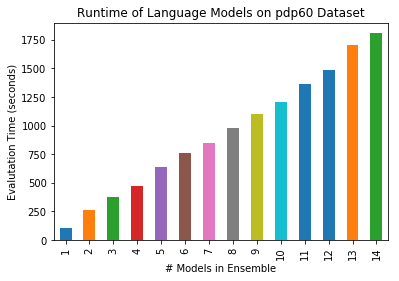

<Figure size 432x288 with 0 Axes>

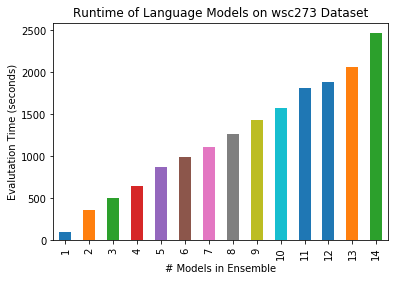

<Figure size 432x288 with 0 Axes>

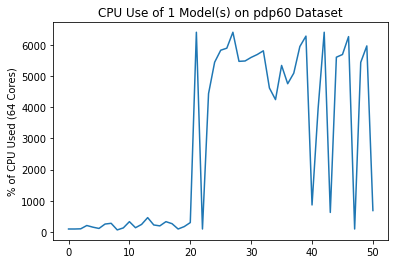

<Figure size 432x288 with 0 Axes>

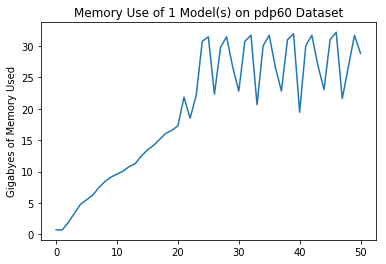

<Figure size 432x288 with 0 Axes>

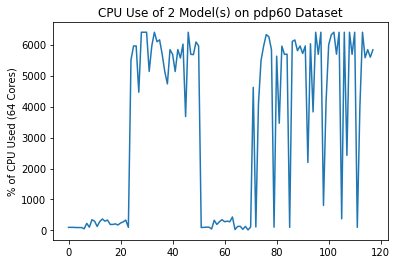

<Figure size 432x288 with 0 Axes>

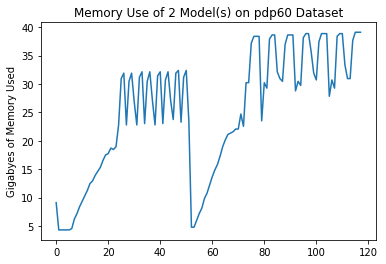

<Figure size 432x288 with 0 Axes>

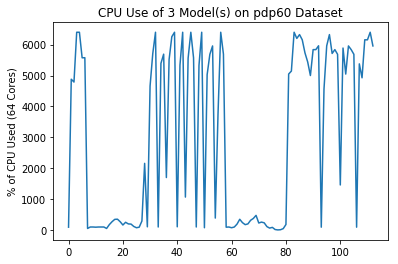

<Figure size 432x288 with 0 Axes>

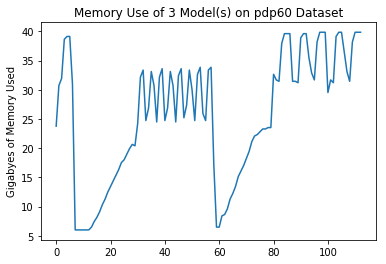

<Figure size 432x288 with 0 Axes>

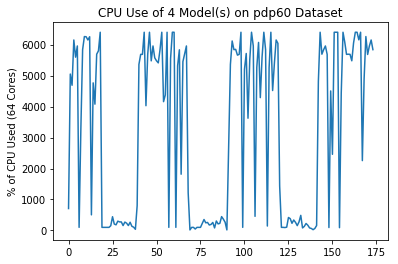

<Figure size 432x288 with 0 Axes>

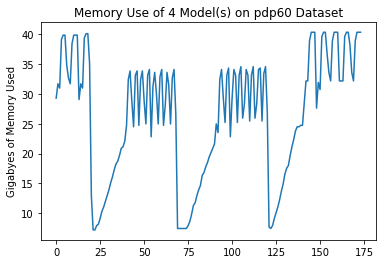

<Figure size 432x288 with 0 Axes>

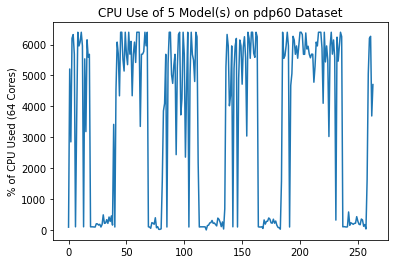

<Figure size 432x288 with 0 Axes>

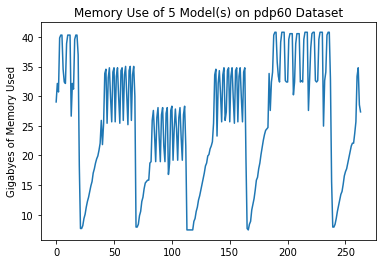

<Figure size 432x288 with 0 Axes>

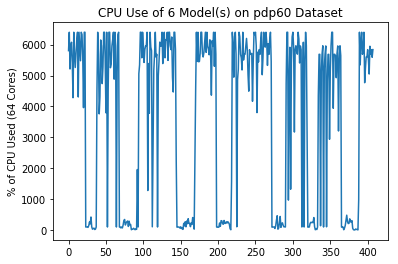

<Figure size 432x288 with 0 Axes>

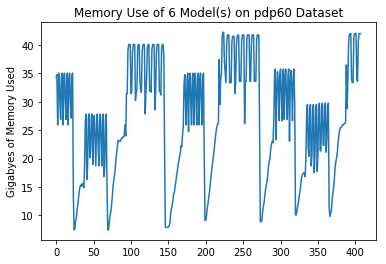

<Figure size 432x288 with 0 Axes>

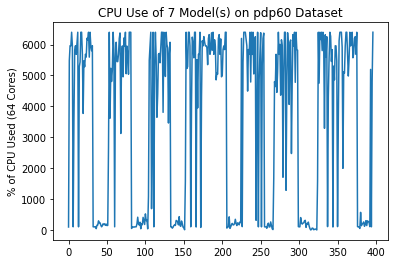

<Figure size 432x288 with 0 Axes>

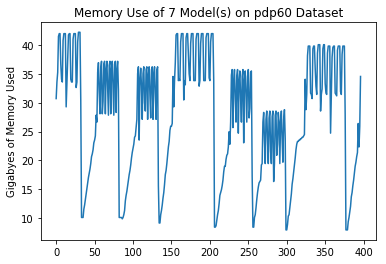

<Figure size 432x288 with 0 Axes>

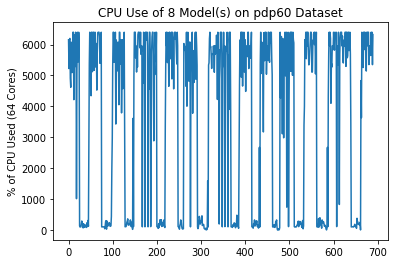

<Figure size 432x288 with 0 Axes>

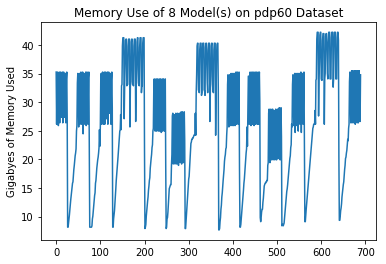

<Figure size 432x288 with 0 Axes>

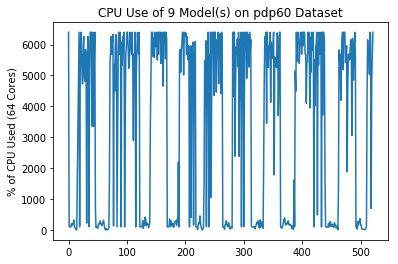

<Figure size 432x288 with 0 Axes>

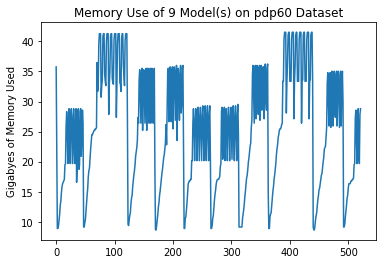

<Figure size 432x288 with 0 Axes>

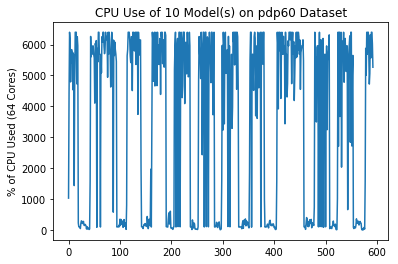

<Figure size 432x288 with 0 Axes>

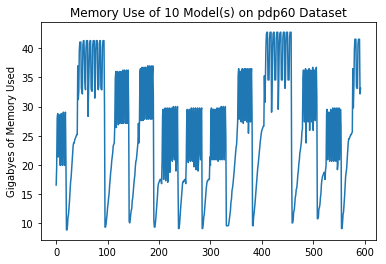

<Figure size 432x288 with 0 Axes>

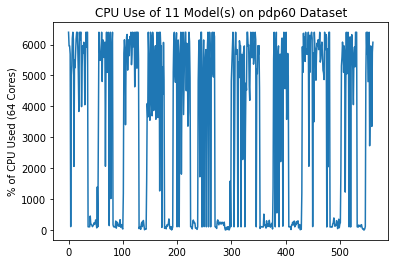

<Figure size 432x288 with 0 Axes>

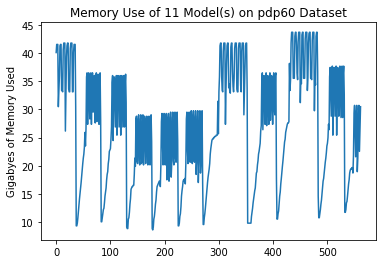

<Figure size 432x288 with 0 Axes>

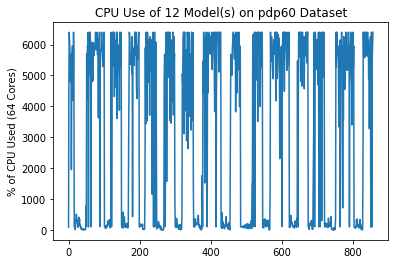

<Figure size 432x288 with 0 Axes>

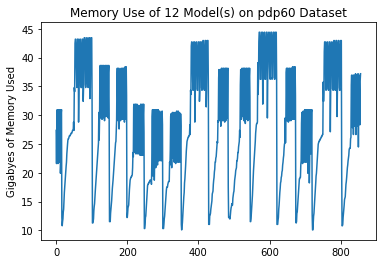

<Figure size 432x288 with 0 Axes>

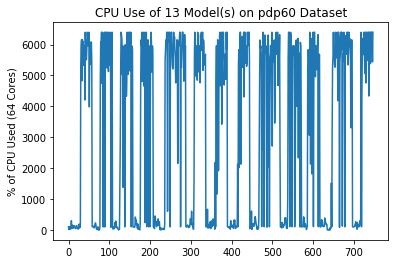

<Figure size 432x288 with 0 Axes>

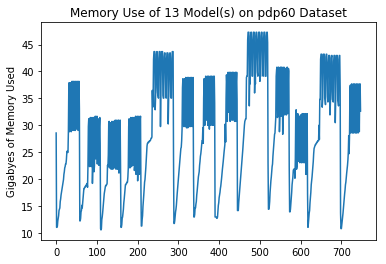

<Figure size 432x288 with 0 Axes>

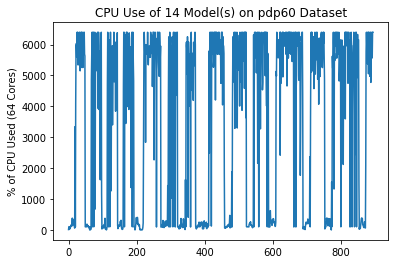

<Figure size 432x288 with 0 Axes>

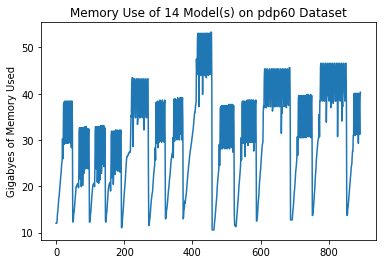

<Figure size 432x288 with 0 Axes>

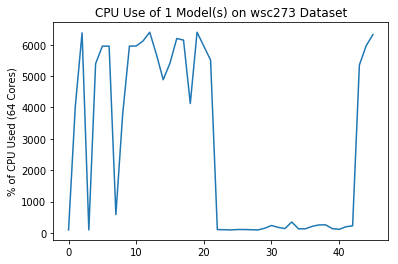

<Figure size 432x288 with 0 Axes>

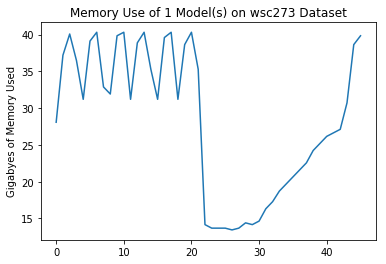

<Figure size 432x288 with 0 Axes>

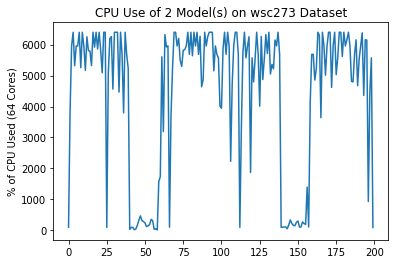

<Figure size 432x288 with 0 Axes>

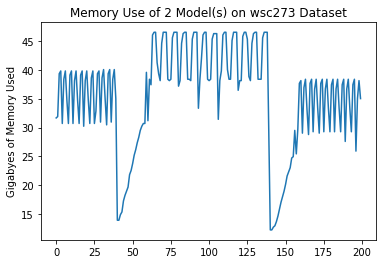

<Figure size 432x288 with 0 Axes>

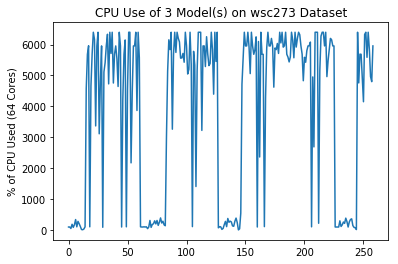

<Figure size 432x288 with 0 Axes>

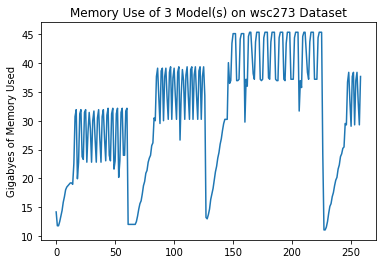

<Figure size 432x288 with 0 Axes>

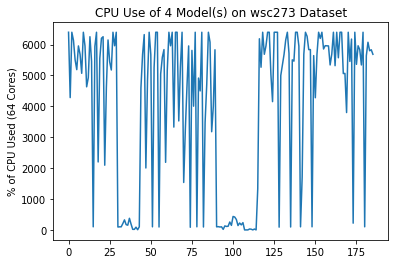

<Figure size 432x288 with 0 Axes>

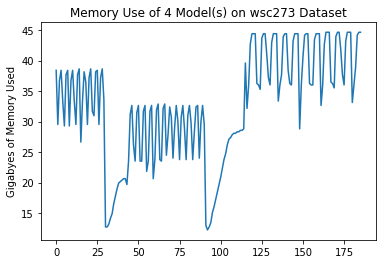

<Figure size 432x288 with 0 Axes>

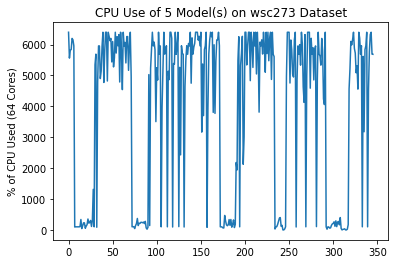

<Figure size 432x288 with 0 Axes>

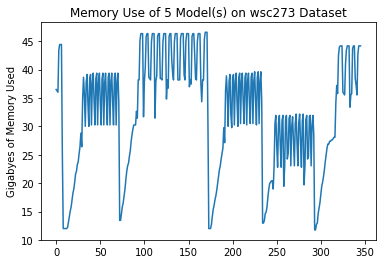

<Figure size 432x288 with 0 Axes>

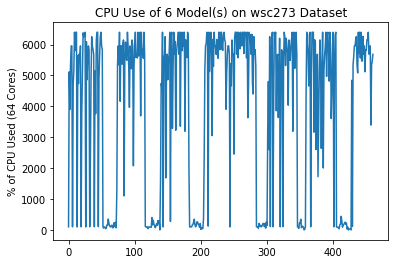

<Figure size 432x288 with 0 Axes>

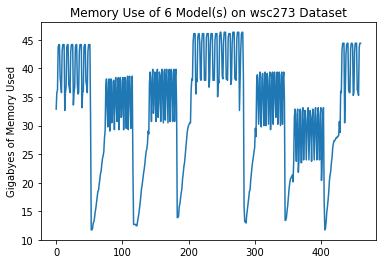

<Figure size 432x288 with 0 Axes>

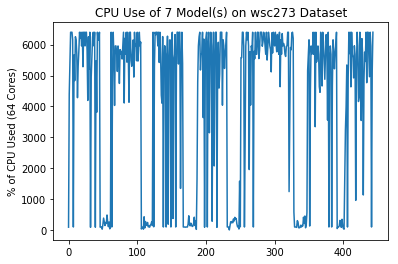

<Figure size 432x288 with 0 Axes>

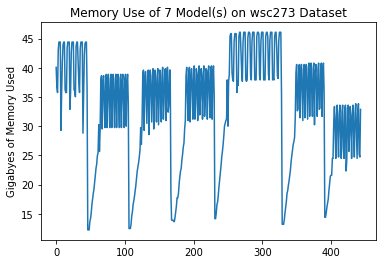

<Figure size 432x288 with 0 Axes>

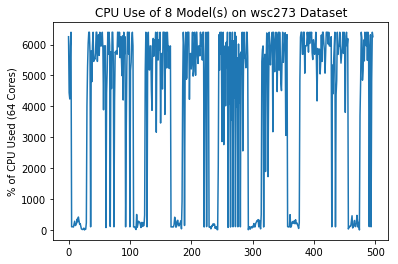

<Figure size 432x288 with 0 Axes>

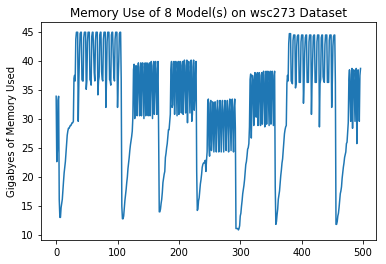

<Figure size 432x288 with 0 Axes>

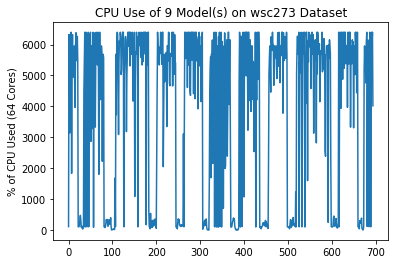

<Figure size 432x288 with 0 Axes>

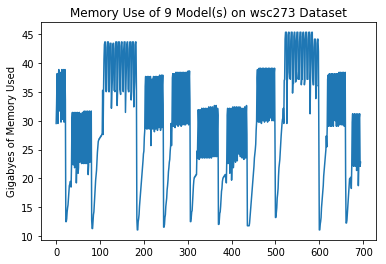

<Figure size 432x288 with 0 Axes>

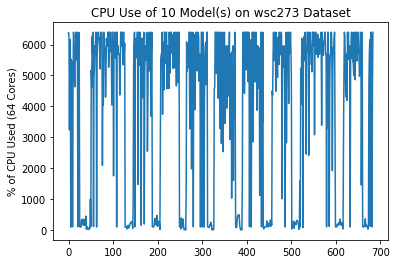

<Figure size 432x288 with 0 Axes>

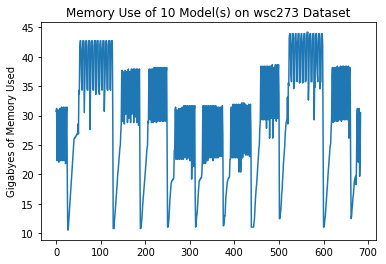

<Figure size 432x288 with 0 Axes>

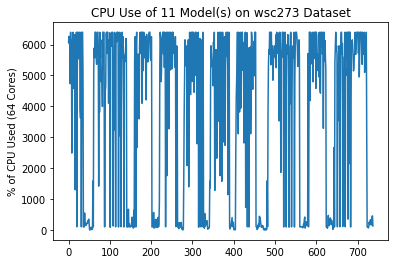

<Figure size 432x288 with 0 Axes>

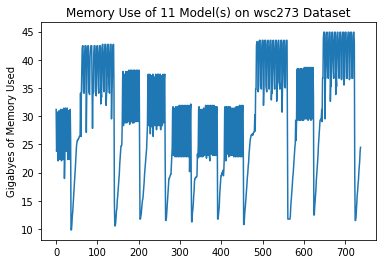

<Figure size 432x288 with 0 Axes>

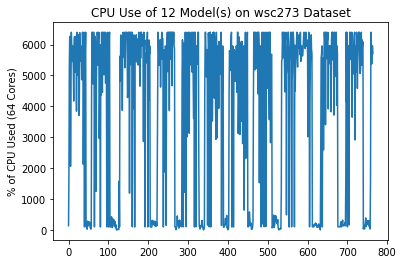

<Figure size 432x288 with 0 Axes>

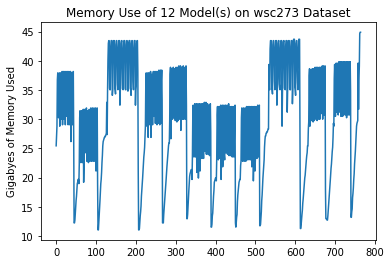

<Figure size 432x288 with 0 Axes>

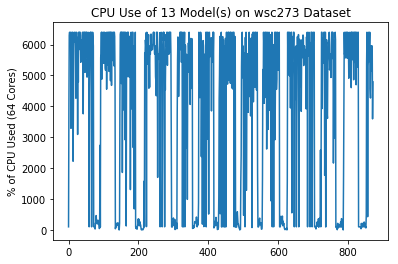

<Figure size 432x288 with 0 Axes>

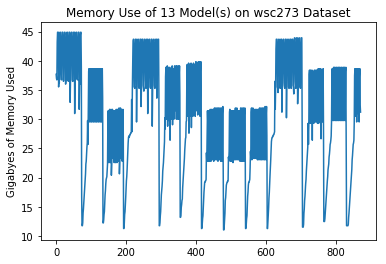

<Figure size 432x288 with 0 Axes>

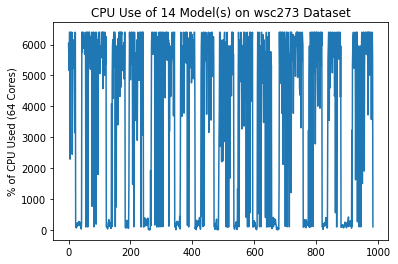

<Figure size 432x288 with 0 Axes>

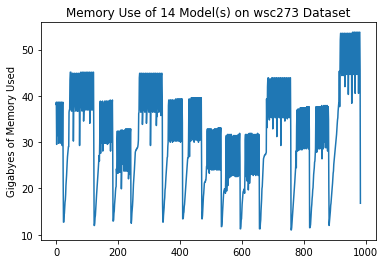

In [14]:
plotAccuracies(accuracy, 'pdp60')
plotAccuracies(accuracy, 'wsc273')
plotRuntime(accuracy, 'pdp60')
plotRuntime(accuracy, 'wsc273')
for i in range(28):
    if i < 14:
        test_set = 'pdp60'
    else:
        test_set = 'wsc273'
    plotCpuUse(model_resources[i], test_set, (i%14 + 1))
    plotMemoryUse(model_resources[i], test_set, (i%14 + 1))
    